## Setup

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Requires TensorFlow >=2.11 for the GroupNormalization layer.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, ConvLSTM2D, BatchNormalization, Conv3D
from tensorflow.keras.callbacks import *

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

2024-07-31 13:30:48.727334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 13:30:48.825911: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 13:30:49.660743: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-07-31 13:30:49.660795: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

## Hyperparameters

In [3]:
batch_size = 256
num_epochs = 800         # Just for the sake of demonstration
total_timesteps = 750   # 1000
norm_groups = 8          # Number of groups used in GroupNormalization layer
learning_rate = 1e-4

img_size_H = 32
img_size_W = 64
img_channels = 5

first_conv_channels = 64
channel_multiplier = [1, 2, 4, 8]
widths = [first_conv_channels * mult for mult in channel_multiplier]
has_attention = [False, False, True, True]
num_res_blocks = 2  # Number of residual blocks

## Gaussian diffusion utilities

We define the **forward process** and the **reverse process** as a separate utility. Most of the code in this utility has been borrowed
from the original implementation with some slight modifications.

In [4]:
from layers.diffusion import GaussianDiffusion

## Network architecture

U-Net, originally developed for semantic segmentation, is an architecture that is
widely used for implementing diffusion models but with some slight modifications:

1. The network accepts two inputs: Image and time step
2. Self-attention between the convolution blocks once we reach a specific resolution
(16x16 in the paper)
3. Group Normalization instead of weight normalization

We implement most of the things as used in the original paper. We use the
`swish` activation function throughout the network. We use the variance scaling
kernel initializer.

The only difference here is the number of groups used for the
`GroupNormalization` layer. For the flowers dataset,
we found that a value of `groups=8` produces better results
compared to the default value of `groups=32`. Dropout is optional and should be
used where chances of over fitting is high. In the paper, the authors used dropout
only when training on CIFAR10.

In [5]:
from tensorflow.keras.models import load_model

pretrained_encoder = load_model('../saved_models/encoder_cnn_56deg_5var.h5')
pretrained_encoder.summary()

Model: "encoder_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 64, 5)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 64, 32)        672       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 64, 128)       16512     
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 64, 256)       131328    
                                                                 
 bottleneck (Conv2D)         (None, 32, 64, 512)       524800    
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 64, 256)       524544    
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 64, 128)       

2024-07-31 13:30:51.238375: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 13:30:51.462830: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 866 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:d6:00.0, compute capability: 8.0


In [6]:
# Extract the first 5 layers
first_five_layers = pretrained_encoder.layers[:5]

# Display the first four layers to confirm
for i, layer in enumerate(first_five_layers):
    print(f"Layer {i}: {layer}")

# Create a new model using these layers
# Get the input of the pre-trained model
input_layer = pretrained_encoder.input

# Get the output of the fourth layer
output_layer = first_five_layers[-1].output

# Create the new model
pretrained_encoder = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Print the summary of the new model
pretrained_encoder.summary()

Layer 0: <keras.engine.input_layer.InputLayer object at 0x7f4fce19a320>
Layer 1: <keras.layers.convolutional.conv2d.Conv2D object at 0x7f4e18aba620>
Layer 2: <keras.layers.convolutional.conv2d.Conv2D object at 0x7f4e18ab9000>
Layer 3: <keras.layers.convolutional.conv2d.Conv2D object at 0x7f4e18ab85b0>
Layer 4: <keras.layers.convolutional.conv2d.Conv2D object at 0x7f4e18a937f0>
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 64, 5)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 64, 32)        672       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 64, 128)       16512     
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 64, 256)       131328    
           

In [7]:
for layer in pretrained_encoder.layers:
    layer.trainable = False

pretrained_encoder._name = 'encoder'

In [8]:
from layers.denoiser import build_unet_model_c2, build_unet_model_c2_no_cross_attn, build_unet_model_c2_no_encoder, build_unet_model_c2_no_cross_attn_encoder

In [9]:
# Build the unet model
network = build_unet_model_c2(
    img_size_H=img_size_H,
    img_size_W=img_size_W,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    first_conv_channels=first_conv_channels,
    activation_fn=keras.activations.swish,
    encoder=pretrained_encoder,
)

image_input_past_embed1 shape: (None, 32, 64, 64)
image_input_past_embed2 shape: (None, 32, 64, 64)
image_input_past shape: (None, 32, 64, 64)
image_input_past shape: (None, 2048, 64)
x.shape: (None, 32, 64, 64) temb.shape: (None, 256)


In [10]:
# network.summary()

## Training

We follow the same setup for training the diffusion model as described
in the paper. We use `Adam` optimizer with a learning rate of `2e-4`.
We use `EMA` (Exponential Moving Average) on model parameters with a decay factor of 0.999. We
treat our model as noise prediction network i.e. at every training step, we
input a batch of images and corresponding time steps to our UNet,
and the network outputs the noise as predictions.


**Note: ** We are using mean squared error as the loss function which is aligned with
the paper, and theoretically makes sense. In practice, though, it is also common to
use mean absolute error or Huber loss as the loss function.

In [11]:
class DiffusionModel(keras.Model):
    def __init__(self, network, ema_network, timesteps, gdf_util, ema=0.999):
        super().__init__()
        self.network = network  # denoiser or noise predictor
        self.ema_network = ema_network
        self.timesteps = timesteps
        self.gdf_util = gdf_util
        self.ema = ema

    def train_step(self, data):
        # Unpack the data
        (images, image_input_past1, image_input_past2), y = data
        
        # 1. Get the batch size
        batch_size = tf.shape(images)[0]
        
        # 2. Sample timesteps uniformly
        t = tf.random.uniform(minval=0, maxval=self.timesteps, shape=(batch_size,), dtype=tf.int64)

        with tf.GradientTape() as tape:
            # 3. Sample random noise to be added to the images in the batch
            noise = tf.random.normal(shape=tf.shape(images), dtype=images.dtype)
            print("noise.shape:", noise.shape)
            
            # 4. Diffuse the images with noise
            images_t = self.gdf_util.q_sample(images, t, noise)
            print("images_t.shape:", images_t.shape)
            
            # 5. Pass the diffused images and time steps to the network
            pred_noise = self.network([images_t, t, image_input_past1, image_input_past2], training=True)
            print("pred_noise.shape:", pred_noise.shape)
            
            # 6. Calculate the loss
            loss = self.loss(noise, pred_noise)

        # 7. Get the gradients
        gradients = tape.gradient(loss, self.network.trainable_weights)

        # 8. Update the weights of the network
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        # 9. Updates the weight values for the network with EMA weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(self.ema * ema_weight + (1 - self.ema) * weight)

        # 10. Return loss values
        return {"loss": loss}

    
    def test_step(self, data):
        # Unpack the data
        (images, image_input_past1, image_input_past2), y = data

        # 1. Get the batch size
        batch_size = tf.shape(images)[0]
        
        # 2. Sample timesteps uniformly
        t = tf.random.uniform(minval=0, maxval=self.timesteps, shape=(batch_size,), dtype=tf.int64)

        # 3. Sample random noise to be added to the images in the batch
        noise = tf.random.normal(shape=tf.shape(images), dtype=images.dtype)
        
        # 4. Diffuse the images with noise
        images_t = self.gdf_util.q_sample(images, t, noise)
        
        # 5. Pass the diffused images and time steps to the network
        pred_noise = self.network([images_t, t, image_input_past1, image_input_past2], training=False)
        
        # 6. Calculate the loss
        loss = self.loss(noise, pred_noise)

        # 7. Return loss values
        return {"loss": loss}

### Load trained model

In [12]:
# Build the unet model
network = build_unet_model_c2(
    img_size_H=img_size_H,
    img_size_W=img_size_W,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    first_conv_channels=first_conv_channels,
    activation_fn=keras.activations.swish,
    encoder=pretrained_encoder,
)

ema_network = build_unet_model_c2(
    img_size_H=img_size_H,
    img_size_W=img_size_W,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    first_conv_channels=first_conv_channels,
    activation_fn=keras.activations.swish,
    encoder=pretrained_encoder,
)
ema_network.set_weights(network.get_weights())  # Initially the weights are the same

image_input_past_embed1 shape: (None, 32, 64, 64)
image_input_past_embed2 shape: (None, 32, 64, 64)
image_input_past shape: (None, 32, 64, 64)
image_input_past shape: (None, 2048, 64)
x.shape: (None, 32, 64, 64) temb.shape: (None, 256)
image_input_past_embed1 shape: (None, 32, 64, 64)
image_input_past_embed2 shape: (None, 32, 64, 64)
image_input_past shape: (None, 32, 64, 64)
image_input_past shape: (None, 2048, 64)
x.shape: (None, 32, 64, 64) temb.shape: (None, 256)


In [13]:
# Get an instance of the Gaussian Diffusion utilities
gdf_util = GaussianDiffusion(timesteps=total_timesteps)

# Get the model
model = DiffusionModel(
    network=network,
    ema_network=ema_network,
    gdf_util=gdf_util,
    timesteps=total_timesteps,
)

In [14]:
# Restore weights
# model.load_weights('../checkpoints/ddpm_weather_56c2_56_5var_cp3')  # CoDiCast with 1000 steps
# model.load_weights('../checkpoints/ddpm_weather_56c2_56_5var_cp3_no_cross_attn')
# model.load_weights('../checkpoints/ddpm_weather_56c2_56_5var_cp3_no_encoder')
# model.load_weights('../checkpoints/ddpm_weather_56c2_56_5var_cp3_no_cross_attn_encoder')
model.load_weights('../checkpoints/ddpm_weather_56c2_56_5var_cp3_750')

## Results

In [15]:
from utils.normalization import batch_norm, batch_norm_reverse
from utils.metrics import lat_weighted_rmse_one_var, lat_weighted_acc_one_var

In [16]:
resolution_folder = '56degree'
resolution = '5.625'  #1.40625, 2.8125, 5.625
var_num = '5'

test_data_tf = np.load("/home/scratch/ERA5/" + resolution_folder + "/merged_data/concat_2017_2018_" + resolution + "_" + var_num + "var.npy")
test_data_tf = test_data_tf.transpose((0, 2, 3, 1))
test_data_tf.shape

(2920, 32, 64, 5)

In [17]:
test_data_tf_norm = batch_norm(test_data_tf, test_data_tf.shape, batch_size=1460)
test_data_tf_norm.shape

(2920, 32, 64, 5)

In [18]:
test_data_tf_norm_pred = test_data_tf_norm[2:]
test_data_tf_norm_past1 = test_data_tf_norm[:-2]
test_data_tf_norm_past2 = test_data_tf_norm[1:-1]

print(test_data_tf_norm_pred.shape, test_data_tf_norm_past1.shape, test_data_tf_norm_past2.shape)

(2918, 32, 64, 5) (2918, 32, 64, 5) (2918, 32, 64, 5)


### RSME & ACC

In [19]:
from utils.normalization import batch_norm, batch_norm_reverse
from utils.metrics import lat_weighted_rmse_one_var, lat_weighted_acc_one_var

In [20]:
import tensorflow as tf
import numpy as np

def generate_images(model, original_samples, original_samples_past1, original_samples_past2):
    """
    @model: trained denoiser
    @original_samples: it just provides the shape, does not involve generation
    @original_samples_past: conditions from the past
    """
    num_images = original_samples.shape[0]
    img_size_H = original_samples.shape[1]
    img_size_W = original_samples.shape[2]
    img_channels = original_samples.shape[3]
    total_timesteps = model.timesteps  # Ensure this is defined in your model

    # 1. Randomly sample noise (starting point for reverse process)
    samples = tf.random.normal(shape=(num_images, img_size_H, img_size_W, img_channels), dtype=tf.float32)
    
    # 2. Sample from the model iteratively
    for t in reversed(range(0, total_timesteps)):
        tt = tf.cast(tf.fill([num_images], t), dtype=tf.int64)
        pred_noise = model.ema_network.predict([samples, tt, original_samples_past1, original_samples_past2],
                                               verbose=0, 
                                               batch_size=num_images
                                              )
        samples = model.gdf_util.p_sample(pred_noise, samples, tt, clip_denoised=True)
        
    # 3. Return generated samples and original samples
    return original_samples, samples
    # return original_samples.numpy(), samples.numpy()

In [21]:
def predict_autoregressive(model, initial_inputs, prediction_horizon):
    
    predictions = []
    
    original_sample, sample_past1, sample_past2 = initial_inputs[0], initial_inputs[1], initial_inputs[2]  # t, t-2, t-1

    for _ in range(prediction_horizon):
        # Predict the next time step
        original_sample, generated_sample = generate_images(model, original_sample, sample_past1, sample_past2)
        
        print("original_sample.shape:", original_sample.shape, "generated_sample.shape:", generated_sample.shape)
        
        # Append the prediction to the list of predictions
        predictions.append(generated_sample)

        sample_past1 = sample_past2
        sample_past2 = generated_sample
        

    # Concatenate predictions along the time steps axis
    predictions = np.concatenate(predictions, axis=0)
    return predictions

In [22]:
channels = ['geopotential_500', 'temperature_850', 
            '2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind']

num_sample = 2
num_channel = 5
num_lead = 6


rmse_matrix = np.zeros((num_sample, num_channel, num_lead))
acc_matrix = np.zeros((num_sample, num_channel, num_lead))


for z in range(num_sample):
    print("sample #", z)
    original_samples = tf.convert_to_tensor(test_data_tf_norm_pred[z:z+num_lead], dtype=tf.float32)
    original_samples_past1 = tf.convert_to_tensor(test_data_tf_norm_past1[z:z+num_lead], dtype=tf.float32)
    original_samples_past2 = tf.convert_to_tensor(test_data_tf_norm_past2[z:z+num_lead], dtype=tf.float32)
    
    print(original_samples.shape, original_samples_past1.shape, original_samples_past2.shape)
    
    initial_inputs = [tf.convert_to_tensor(original_samples[0:1], dtype=tf.float32),
                  tf.convert_to_tensor(original_samples_past1[0:1], dtype=tf.float32), 
                  tf.convert_to_tensor(original_samples_past2[0:1], dtype=tf.float32)
                 ]

    future_predictions = predict_autoregressive(model, initial_inputs, prediction_horizon=num_lead)

    original_samples_unnormlalized = batch_norm_reverse(test_data_tf, test_data_tf.shape, 1459, original_samples)
    generated_samples_unnormlalized = batch_norm_reverse(test_data_tf, test_data_tf.shape, 1459, future_predictions)
    
    print(original_samples_unnormlalized.shape, generated_samples_unnormlalized.shape)
    
    
    for i in range(num_channel):
        print(f'{channels[i]}:')
        for j in range(num_lead):
            # print(f't{num_lead*(j+1)}: {lat_weighted_rmse_one_var(original_samples_unnormlalized[j:j+1], generated_samples_unnormlalized[j:j+1], var_idx=i, resolution=5.625):.5f}')
            rmse_matrix[z][i][j] = lat_weighted_rmse_one_var(original_samples_unnormlalized[j:j+1], generated_samples_unnormlalized[j:j+1], var_idx=i, resolution=5.625)
            acc_matrix[z][i][j] = lat_weighted_acc_one_var(original_samples_unnormlalized[j:j+1], generated_samples_unnormlalized[j:j+1], var_idx=i, resolution=5.625, clim=test_data_tf)
        print('\n')

    print("rmse_matrix.shape:", rmse_matrix.shape)
    print("acc_matrix.shape:", acc_matrix.shape)

sample # 0
(6, 32, 64, 5) (6, 32, 64, 5) (6, 32, 64, 5)


2024-07-31 13:31:12.914210: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-07-31 13:31:12.938321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-31 13:31:12.970856: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-31 13:31:12.970906: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-31 13:31:12.970913: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

NotFoundError: Graph execution error:

Detected at node 'unet/conv2d_142/Conv2D' defined at (most recent call last):
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_237869/3215911981.py", line 26, in <module>
      future_predictions = predict_autoregressive(model, initial_inputs, prediction_horizon=num_lead)
    File "/tmp/ipykernel_237869/569793758.py", line 9, in predict_autoregressive
      original_sample, generated_sample = generate_images(model, original_sample, sample_past1, sample_past2)
    File "/tmp/ipykernel_237869/2287964148.py", line 22, in generate_images
      pred_noise = model.ema_network.predict([samples, tt, original_samples_past1, original_samples_past2],
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/keras/engine/training.py", line 2350, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/keras/engine/training.py", line 2137, in predict_function
      return step_function(self, iterator)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/keras/engine/training.py", line 2123, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in run_step
      outputs = model.predict_step(data)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/keras/engine/training.py", line 2079, in predict_step
      return self(x, training=False)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'unet/conv2d_142/Conv2D'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 4#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 103328256 bytes.
  Profiling failure on CUDNN engine 4: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 103328256 bytes.
  Profiling failure on CUDNN engine 6#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16867072 bytes.
  Profiling failure on CUDNN engine 6: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16867072 bytes.
  Profiling failure on CUDNN engine 5#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 20206592 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 20206592 bytes.
  Profiling failure on CUDNN engine 7#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 38692864 bytes.
  Profiling failure on CUDNN engine 7: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 38692864 bytes.
	 [[{{node unet/conv2d_142/Conv2D}}]] [Op:__inference_predict_function_38688]

In [ ]:
# ddpm_weather_56c2_56_5var_cp3_750
rmse_matrix_mean = np.mean(rmse_matrix, axis=0)
rmse_matrix_mean

In [122]:
# ddpm_weather_56c2_56_5var_cp3_2000
rmse_matrix_mean = np.mean(rmse_matrix, axis=0)
rmse_matrix_mean

array([[ 75.31446598, 118.61657752, 156.25411582, 191.99010922,
        227.58628592, 262.73473451],
       [  1.0541559 ,   1.31239267,   1.45712234,   1.5813485 ,
          1.70131377,   1.81435104],
       [  0.99320368,   1.27392109,   1.42306882,   1.53402841,
          1.66446288,   1.78812323],
       [  1.35195516,   1.64847343,   1.83743308,   2.01345755,
          2.20459203,   2.4052413 ],
       [  1.41278912,   1.69623021,   1.88607756,   2.06469712,
          2.26125132,   2.47724609]])

In [74]:
# ddpm_weather_56c2_56_5var_cp3_1500
rmse_matrix_mean = np.mean(rmse_matrix, axis=0)
rmse_matrix_mean

array([[ 73.78568118, 117.27325849, 155.73382188, 193.56509624,
        231.47183558, 267.31411946],
       [  1.04511947,   1.28085036,   1.43410836,   1.56000864,
          1.67358435,   1.79098063],
       [  0.98322579,   1.26140099,   1.39031463,   1.50697572,
          1.60555682,   1.70917819],
       [  1.31083722,   1.60623099,   1.79358812,   1.99052147,
          2.16484917,   2.36356273],
       [  1.37958432,   1.67428318,   1.85187779,   2.04999352,
          2.25223762,   2.46002118]])

In [98]:
# ddpm_weather_56c2_56_5var_cp3_1000
rmse_matrix_mean = np.mean(rmse_matrix, axis=0)
rmse_matrix_mean

array([[ 73.02552202, 114.422306  , 152.45063746, 186.5693085 ,
        220.55508791, 256.79041341],
       [  1.02710011,   1.26437616,   1.4104049 ,   1.5275315 ,
          1.6513629 ,   1.77729159],
       [  0.95528369,   1.21117198,   1.34682806,   1.45467671,
          1.56014968,   1.65473795],
       [  1.2400641 ,   1.50469205,   1.68768223,   1.87618164,
          2.06310454,   2.25252364],
       [  1.30726323,   1.56589895,   1.75184579,   1.94552859,
          2.15411255,   2.35724811]])

In [24]:
# ddpm_weather_56c2_56_5var_cp3_750
rmse_matrix_mean = np.mean(rmse_matrix, axis=0)
rmse_matrix_mean

array([[121.2697301 , 116.94024583, 189.21189891, 190.63988611,
        262.06414696, 255.96997456],
       [  1.30155875,   1.27624849,   1.47408201,   1.53149632,
          1.73182746,   1.8236781 ],
       [  1.29038748,   1.26321169,   1.58212265,   1.63431773,
          1.83170713,   1.97540999],
       [  1.49589433,   1.42050271,   1.77672916,   1.81203116,
          2.18985692,   2.16383059],
       [  1.54788349,   1.55388995,   1.84664544,   1.89290498,
          2.1970252 ,   2.18519113]])

In [36]:
# ddpm_weather_56c2_56_5var_cp3_500
rmse_matrix_mean = np.mean(rmse_matrix, axis=0)
rmse_matrix_mean

array([[187.97521378, 178.75026276, 331.6539307 , 324.85823327,
        452.13959201, 472.61285662],
       [  1.65030307,   1.65704313,   2.25935069,   2.38126284,
          3.03221852,   3.14787833],
       [  1.75217742,   1.73472554,   2.62664331,   2.79648157,
          3.42698551,   3.7433042 ],
       [  1.62931761,   1.59973752,   2.04596243,   2.05935766,
          2.61604553,   2.64030844],
       [  1.63134338,   1.64551692,   2.01758194,   2.11079738,
          2.44973989,   2.55869437]])

In [24]:
# ddpm_weather_56c2_56_5var_cp3_250
rmse_matrix_mean = np.mean(rmse_matrix, axis=0)
rmse_matrix_mean

array([[341.01804126, 359.60178859, 664.65979409, 696.14208117,
        970.9282868 , 973.89429937],
       [  2.41978096,   2.33858318,   3.94541779,   3.88409168,
          5.59475043,   5.3288484 ],
       [  3.06844585,   3.25188258,   5.41123617,   5.26788756,
          7.45698095,   7.07639387],
       [  1.90305308,   1.91975599,   2.6594314 ,   2.74057228,
          3.5812893 ,   3.65478834],
       [  1.87279435,   1.79967881,   2.47285628,   2.42790367,
          3.20993294,   3.20399636]])

In [25]:
acc_matrix_mean = np.mean(acc_matrix, axis=0)
acc_matrix_mean

array([[0.99420299, 0.99356208, 0.98757958, 0.9860635 , 0.97916608,
        0.97651018],
       [0.96343955, 0.96603362, 0.95830086, 0.95385759, 0.94998394,
        0.94422749],
       [0.97771546, 0.97793882, 0.9746469 , 0.97346511, 0.96978223,
        0.97392648],
       [0.9183838 , 0.9154003 , 0.89314791, 0.88816625, 0.84549472,
        0.8234678 ],
       [0.91952638, 0.91839879, 0.886373  , 0.87981763, 0.84345327,
        0.81715004]])

### CRPS

In [45]:
channels = ['geopotential_500', 'temperature_850', 
            '2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind']

num_sample = 2
num_channel = 5
num_lead = 6


rmse_matrix = np.zeros((num_sample, num_channel, num_lead))
acc_matrix = np.zeros((num_sample, num_channel, num_lead))
true, pred = [], []

for z in range(num_sample):
    #print("sample #", z)
    original_samples = tf.convert_to_tensor(test_data_tf_norm_pred[z:z+num_lead], dtype=tf.float32)
    original_samples_past1 = tf.convert_to_tensor(test_data_tf_norm_past1[z:z+num_lead], dtype=tf.float32)
    original_samples_past2 = tf.convert_to_tensor(test_data_tf_norm_past2[z:z+num_lead], dtype=tf.float32)
    
    print(original_samples.shape, original_samples_past1.shape, original_samples_past2.shape)
    
    initial_inputs = [tf.convert_to_tensor(original_samples[0:1], dtype=tf.float32),
                  tf.convert_to_tensor(original_samples_past1[0:1], dtype=tf.float32), 
                  tf.convert_to_tensor(original_samples_past2[0:1], dtype=tf.float32)
                 ]

    future_predictions = predict_autoregressive(model, initial_inputs, prediction_horizon=num_lead)

    original_samples_unnormlalized = batch_norm_reverse(test_data_tf, test_data_tf.shape, 1459, original_samples)
    generated_samples_unnormlalized = batch_norm_reverse(test_data_tf, test_data_tf.shape, 1459, future_predictions)
    
    print(original_samples_unnormlalized.shape, generated_samples_unnormlalized.shape)
    true.append(original_samples_unnormlalized)
    pred.append(generated_samples_unnormlalized)
    
    
    for i in range(num_channel):
        print(f'{channels[i]}:')
        for j in range(num_lead):
            # print(f't{num_lead*(j+1)}: {lat_weighted_rmse_one_var(original_samples_unnormlalized[j:j+1], generated_samples_unnormlalized[j:j+1], var_idx=i, resolution=5.625):.5f}')
            rmse_matrix[z][i][j] = lat_weighted_rmse_one_var(original_samples_unnormlalized[j:j+1], generated_samples_unnormlalized[j:j+1], var_idx=i, resolution=5.625)
            acc_matrix[z][i][j] = lat_weighted_acc_one_var(original_samples_unnormlalized[j:j+1], generated_samples_unnormlalized[j:j+1], var_idx=i, resolution=5.625, clim=test_data_tf)
        print('\n')

    print("rmse_matrix.shape:", rmse_matrix.shape)
    print("acc_matrix.shape:", acc_matrix.shape)

(6, 32, 64, 5) (6, 32, 64, 5) (6, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
(6, 32, 64, 5) (6, 32, 64, 5)
geopotential_500:


temperature_850:


2m_temperature:


10m_u_component_of_wind:


10m_v_component_of_wind:


rmse_matrix.shape: (2, 5, 6)
acc_matrix.shape: (2, 5, 6)
(6, 32, 64, 5) (6, 32, 64, 5) (6, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.sha

In [41]:
true_concat = np.stack(true)
true_concat.shape

(2, 6, 32, 64, 5)

In [44]:
pred_concat_ens1 = np.stack(pred)
pred_concat_ens1.shape

(2, 6, 32, 64, 5)

In [46]:
pred_concat_ens2 = np.stack(pred)
pred_concat_ens2.shape

(2, 6, 32, 64, 5)

In [48]:
pred_concat_ens = np.stack((pred_concat_ens1, pred_concat_ens2), axis=1)
pred_concat_ens.shape

(2, 2, 6, 32, 64, 5)

In [51]:
import numpy as np

def crps_ensemble(y_pred, y_true):
    """
    Compute the CRPS for an ensemble forecast for each time step and each variable.
    
    Parameters:
    y_pred (numpy.ndarray): Ensemble predictions, shape (n_ensemble_members, n_samples, n_time_steps, n_lat, n_lon, n_vars)
    y_true (numpy.ndarray): True values, shape (n_samples, n_time_steps, n_lat, n_lon, n_vars)
    
    Returns:
    numpy.ndarray: CRPS scores, shape (n_time_steps, n_vars)
    """
    n_ensemble_members, n_samples, n_time_steps, n_lat, n_lon, n_vars = y_pred.shape
    crps_scores = np.zeros((n_time_steps, n_vars))

    for time_step in range(n_time_steps):
        for var in range(n_vars):
            
            crps_time_var = []
            for sample in range(n_samples):
                for lat in range(n_lat):
                    for lon in range(n_lon):
                        forecast = y_pred[:, sample, time_step, lat, lon, var]
                        obs = y_true[sample, time_step, lat, lon, var]
                        
                        # CRPS calculation for a single sample, time step, lat, lon, and variable
                        score = np.mean((forecast - obs)**2)
                        score -= 0.5 * np.mean((forecast[:, None] - forecast[None, :])**2)
                        crps_time_var.append(score)
            crps_scores[time_step, var] = np.mean(crps_time_var)
    
    return crps_scores

# Example usage
y_true = np.random.rand(10, 6, 32, 64, 5)  # True values
y_pred = np.random.rand(3, 10, 6, 32, 64, 5)  # Ensemble predictions

crps_scores = crps_ensemble(y_pred, y_true)
print(f"CRPS scores:\n {crps_scores}")


CRPS scores:
 [[0.11158534 0.11147411 0.11095188 0.11124884 0.11076659]
 [0.11199742 0.11146648 0.11126124 0.11006384 0.11175391]
 [0.11131499 0.11134729 0.11126647 0.11093706 0.11156448]
 [0.11066336 0.11332736 0.1111743  0.11122868 0.11317428]
 [0.11100054 0.1120338  0.11186152 0.11111726 0.11126395]
 [0.11064187 0.11055054 0.11050221 0.11114363 0.11076864]]


In [61]:
import numpy as np
from properscoring import crps_gaussian

def compute_crps_gaussian(y_pred_mean, y_pred_std, y_true):
    """
    Compute the CRPS for Gaussian ensemble forecasts for each time step and each variable.
    
    Parameters:
    y_pred_mean (numpy.ndarray): Mean of ensemble predictions, shape (n_samples, n_time_steps, n_lat, n_lon, n_vars)
    y_pred_std (numpy.ndarray): Standard deviation of ensemble predictions, shape (n_samples, n_time_steps, n_lat, n_lon, n_vars)
    y_true (numpy.ndarray): True values, shape (n_samples, n_time_steps, n_lat, n_lon, n_vars)
    
    Returns:
    numpy.ndarray: CRPS scores, shape (n_time_steps, n_vars)
    """
    n_samples, n_time_steps, n_lat, n_lon, n_vars = y_true.shape
    crps_scores = np.zeros((n_time_steps, n_vars))

    for time_step in range(n_time_steps):
        for var in range(n_vars):
            crps_time_var = []
            for sample in range(n_samples):
                for lat in range(n_lat):
                    for lon in range(n_lon):
                        mean = y_pred_mean[sample, time_step, lat, lon, var]
                        std = y_pred_std[sample, time_step, lat, lon, var]
                        obs = y_true[sample, time_step, lat, lon, var]
                        
                        # Compute CRPS for Gaussian forecast
                        score = crps_gaussian(obs, mean, std)
                        crps_time_var.append(score)
            crps_scores[time_step, var] = np.mean(crps_time_var)
    
    return crps_scores

# Example usage
n_samples = 10
n_time_steps = 6
n_lat = 32
n_lon = 64
n_vars = 5
n_ensemble_members = 3

y_true = np.random.rand(n_samples, n_time_steps, n_lat, n_lon, n_vars)  # True values
y_pred = np.random.rand(n_ensemble_members, n_samples, n_time_steps, n_lat, n_lon, n_vars)  # Ensemble predictions

# Compute mean and standard deviation of ensemble predictions
y_pred_mean = np.mean(y_pred, axis=0)
y_pred_std = np.std(y_pred, axis=0)

crps_scores = compute_crps_gaussian(y_pred_mean, y_pred_std, y_true)
print(f"CRPS scores:\n {crps_scores}")

CRPS scores:
 [[0.20973914 0.21085821 0.21073165 0.20859181 0.20971608]
 [0.20889394 0.21038276 0.20931646 0.20895524 0.20905459]
 [0.20955105 0.20929701 0.21072419 0.2110342  0.20927491]
 [0.20860044 0.20993743 0.2101803  0.20970537 0.21013852]
 [0.20959223 0.20888838 0.20968958 0.20802077 0.21064001]
 [0.21002465 0.21094046 0.21107889 0.21122561 0.21078557]]


In [62]:
# Compute mean and standard deviation of ensemble predictions
y_pred_mean = np.mean(pred_concat_ens, axis=0)
y_pred_std = np.std(pred_concat_ens, axis=0)
y_true = true_concat

crps_scores = compute_crps_gaussian(y_pred_mean, y_pred_std, y_true)
print(f"CRPS scores:\n {crps_scores}")

/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/properscoring/_crps.py:66: RuntimeWarning: divide by zero encountered in divide
  sx = (x - mu) / sig
/aul/homes/jshi008/miniconda3/envs/diffusion/lib/python3.10/site-packages/properscoring/_crps.py:72: RuntimeWarning: invalid value encountered in multiply
  crps = sig * (sx * (2 * cdf - 1) + 2 * pdf - pi_inv)


CRPS scores:
 [[ 65.75673672   0.56199661   0.64402826   0.73985062   0.7940269 ]
 [ 86.7685274    0.7142034    0.73477536   0.88305894   0.90707436]
 [113.24982023   0.81891089   0.88440103   0.94510483   1.00055743]
 [132.29820311   0.92016453          nan   1.03483256   1.1432345 ]
 [152.51026284   1.00089248   1.00717813   1.15211905   1.22785811]
 [171.1996789    1.04688436   1.04148062   1.27194684   1.33390662]]


In [63]:
y_pred_std.shape

(2, 6, 32, 64, 5)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


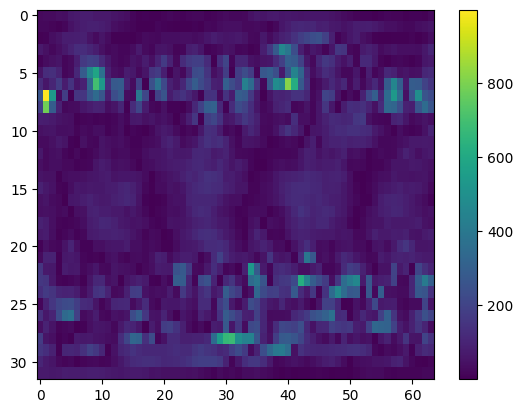

In [66]:
plt.imshow(y_pred_std[0, 0, :, :, 0], aspect='auto', cmap='viridis')
plt.colorbar()  # Add the color bar
plt.show()  # Display the plot

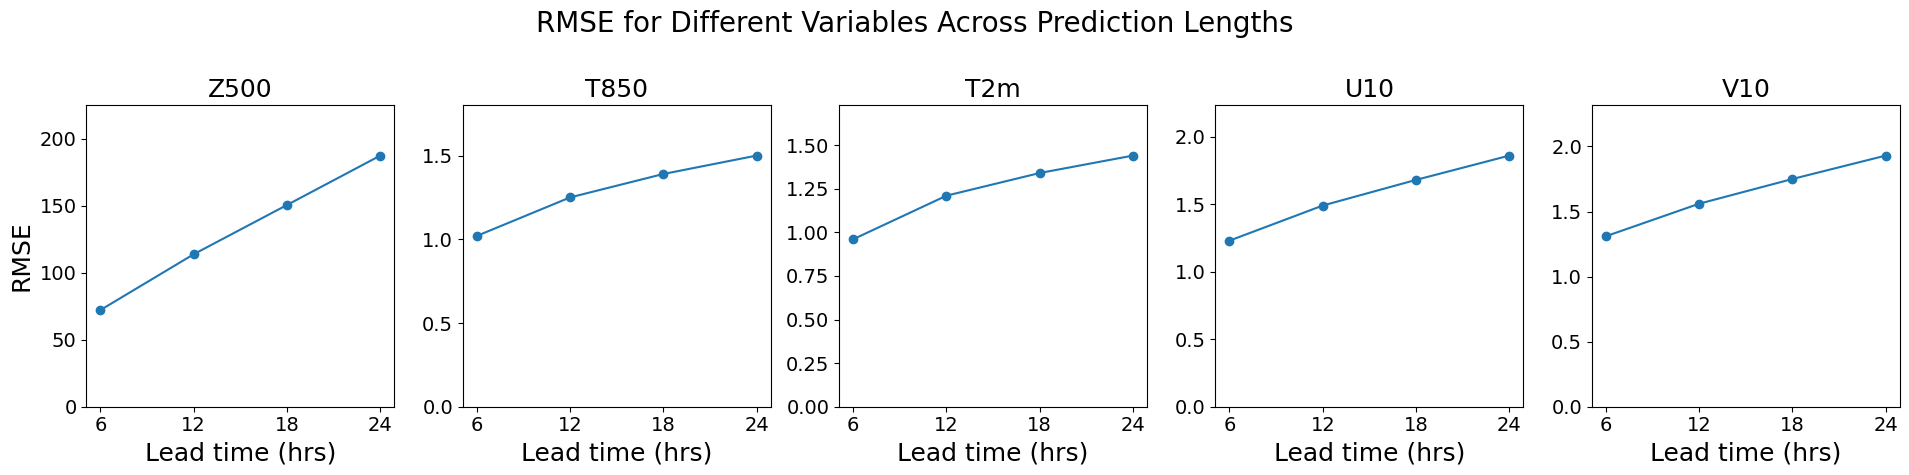

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Updated RMSE matrix without the last column
rmse = np.array([
    [ 72.2, 113.9, 150.7, 187.6],
    [  1.02,   1.25,   1.39,   1.50],
    [  0.96,   1.21,   1.34,   1.44],
    [  1.23,   1.49 ,   1.68,   1.86],
    [  1.31,   1.56 ,   1.75,   1.93]
])

# Updated prediction lengths
prediction_lengths = np.array([6, 12, 18, 24])

variable_names = ['Z500', 'T850', 'T2m', 'U10', 'V10']

# Create subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# Plot each variable in a separate subplot
for i in range(rmse.shape[0]):
    axs[i].plot(prediction_lengths, rmse[i, :], marker='o')
    axs[i].set_title(variable_names[i], fontsize=18)
    axs[i].set_xlabel('Lead time (hrs)', fontsize=18)
    axs[i].set_xticks(prediction_lengths)
    axs[i].set_xticklabels(prediction_lengths, fontsize=14)  # Adjust x-tick label size
    axs[i].tick_params(axis='y', labelsize=14)  # Adjust y-tick label size
    axs[i].set_ylim([0, max(rmse[i, :]) * 1.2])  # Adjust y-axis scale to fit the data with some margin
    if i == 0:
        axs[i].set_ylabel('RMSE', fontsize=18)

# Set a common y-label
# fig.text(0.04, 0.5, 'RMSE', va='center', rotation='vertical', fontsize=18)

plt.suptitle('RMSE for Different Variables Across Prediction Lengths', fontsize=20)
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()

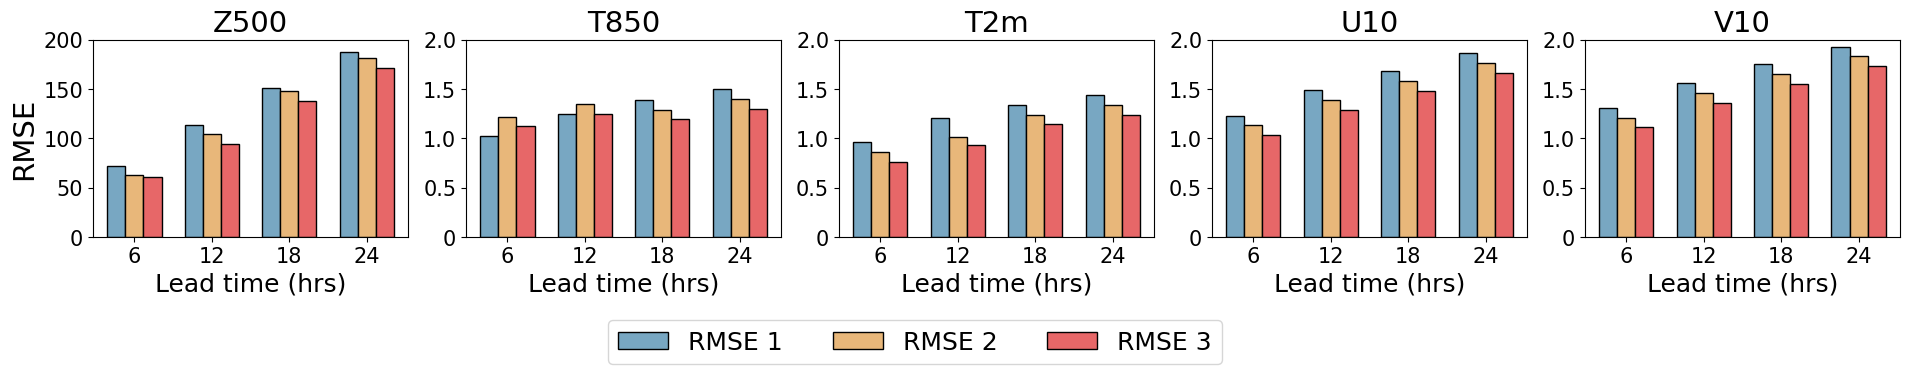

In [148]:
import matplotlib.pyplot as plt
import numpy as np

# First RMSE matrix
rmse1 = np.array([
    [ 72.2, 113.9, 150.7, 187.6],
    [  1.02,   1.25,   1.39,   1.50],
    [  0.96,   1.21,   1.34,   1.44],
    [  1.23,   1.49 ,   1.68,   1.86],
    [  1.31,   1.56 ,   1.75,   1.93]
])

# Second RMSE matrix
rmse2 = np.array([
    [ 62.2, 103.9, 147.7, 181.6],
    [  1.22,   1.35,   1.29,   1.40],
    [  0.86,   1.01,   1.24,   1.34],
    [  1.13,   1.39 ,   1.58,   1.76],
    [  1.21,   1.46 ,   1.65,   1.83]
])

# Simulated third RMSE matrix
rmse3 = np.array([
    [ 60.2, 93.9, 137.7, 171.6],
    [  1.12,   1.25,   1.19,   1.30],
    [  0.76,   0.93,   1.14,   1.24],
    [  1.03,   1.29 ,   1.48,   1.66],
    [  1.11,   1.36 ,   1.55,   1.73]
])


# Prediction lengths
prediction_lengths = np.array([6, 12, 18, 24])
variable_names = ['Z500', 'T850', 'T2m', 'U10', 'V10']

# Create subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 3.6))

bar_width = 1.4  # Width of the bars
offset = bar_width  # Offset for each set of bars

# Define colors for each RMSE matrix
# colors = ['#F195AA', '#75B1DA', '#ECC46E']
colors = ['#78A7C2', '#E8B77A', '#E76768']

hatches = ['/', '\\', '..']

# Plot each variable in a separate subplot
for i in range(rmse1.shape[0]):
    # axs[i].bar(prediction_lengths - offset, rmse1[i, :], width=bar_width, label='RMSE 1', color=colors[0], hatch=hatches[0], edgecolor='black')
    # axs[i].bar(prediction_lengths, rmse2[i, :], width=bar_width, label='RMSE 2', color=colors[1], hatch=hatches[1], edgecolor='black')
    # axs[i].bar(prediction_lengths + offset, rmse3[i, :], width=bar_width, label='RMSE 3', color=colors[2], hatch=hatches[2], edgecolor='black')
    axs[i].bar(prediction_lengths - offset, rmse1[i, :], width=bar_width, label='RMSE 1', color=colors[0], edgecolor='black')
    axs[i].bar(prediction_lengths, rmse2[i, :], width=bar_width, label='RMSE 2', color=colors[1], edgecolor='black')
    axs[i].bar(prediction_lengths + offset, rmse3[i, :], width=bar_width, label='RMSE 3', color=colors[2], edgecolor='black')
    axs[i].set_title(variable_names[i], fontsize=21)
    axs[i].set_xlabel('Lead time (hrs)', fontsize=18)
    axs[i].set_xticks(prediction_lengths)
    axs[i].set_xticklabels(prediction_lengths, fontsize=15)  # Adjust x-tick label size
    axs[i].tick_params(axis='y', labelsize=14)  # Adjust y-tick label size
    axs[i].set_ylim([0, max(max(rmse1[i, :]), max(rmse2[i, :]), max(rmse3[i, :]))])  # Adjust y-axis scale to fit the data with some margin
    if i == 0:
        axs[i].set_ylabel('RMSE', fontsize=21)
        axs[i].set_yticks([0, 50, 100, 150, 200])  # Set specific y-tick labels for the first subplot
        axs[i].set_yticklabels([0, 50, 100, 150, 200], fontsize=15)  # Set y-tick labels for the first subplot
    else:
        axs[i].set_yticks([0, 0.5, 1.0, 1.5, 2.0])  # Set specific y-tick labels for last 4 subplots
        axs[i].set_yticklabels([0, 0.5, 1.0, 1.5, 2.0], fontsize=15)  # Set y-tick labels

# Create a single legend for the entire figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.09), ncol=3, fontsize=18)

# plt.suptitle('RMSE for Different Variables Across Prediction Lengths', fontsize=20)
plt.tight_layout(rect=[0.04, 0.08, 1, 0.96])
plt.show()
